# Logistic Regression for QAM Demodulation in AWGN Channels

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code serves as:
* an exercise to demodulate QAM symbols using multiclass logistic regression

In [1]:
import numpy as np
    
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib inline 


Here we use a simple AWGN model and normalize the constellations to unit energy

In [2]:
constellations = {'16-QAM': np.array([-3,-3,-3,-3,-1,-1,-1,-1,1,1,1,1,3,3,3,3]) + 1j*np.array([-3,-1,1,3,-3,-1,1,3,-3,-1,1,3,-3,-1,1,3]), \
                  '16-APSK': np.array([1,-1,0,0,1.4,1.4,-1.4,-1.4,3,-3,0,0,5,-5,0,0]) + 1j*np.array([0,0,1,-1,1.4,-1.4,1.4,-1.4,0,0,4,-4,0,0,6,-6]), \
                  '4-test' : np.array([-1,2,0,4]) + 1j*np.array([0,0,3,0])}

# permute constellations so that it is visually more appealing with the chosen colormap
# also normalize constellation
for cname in constellations.keys():
    norm_factor = 1 / np.sqrt(np.mean(np.abs(constellations[cname])**2))
    constellations[cname] = constellations[cname][np.random.permutation(len(constellations[cname]))] * norm_factor
    

constellation = constellations['16-QAM']
n = len(constellation)

Simple AWGN channel

In [3]:
def simulate_channel(x, SNR):  
    # noise variance per step    
    sigma = np.sqrt( 0.5 * (10**(-SNR/10.0)) )

    return x + sigma*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))    

In [4]:
length = 10000

def plot_constellation(SNR):
    ti = np.random.randint(len(constellation),size=length)
    t = constellation[ti]
    r = simulate_channel(t, SNR)

    plt.figure(figsize=(6,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=True)
    plt.scatter(np.real(r), np.imag(r), c=ti, cmap='tab20')
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    plt.title('Received constellation (SNR = $%1.2f$\,dBm)' % (SNR))    
    
interactive_update = interactive(plot_constellation, SNR = widgets.FloatSlider(min=0.0,max=30.0,step=0.1,value=15, continuous_update=False, description='SNR (dB)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')))


output = interactive_update.children[-1]
output.layout.height = '500px'
interactive_update

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='SNR (dB)', layout=Layout(w…

Helper functions for plotting the constellations and the decision region of the different constellations and classifiers

In [5]:
def plot_dec(t, r, weights, title):
    ext_x = max(abs(np.real(r)))
    ext_y = max(abs(np.imag(r)))
    ext_max = max(ext_x,ext_y)*1.2

    mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
    meshgrid = np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1))))
    
    decision_region = np.argmax(logistic_prediction(meshgrid, weights), axis=1) / 16    
    
    plt.figure(figsize=(8,8))    
    #plt.scatter(mgx,mgy,c = decision_region,cmap='tab20', s=5, alpha=0.7)
    plt.scatter(meshgrid[:,0],meshgrid[:,1],c = decision_region,cmap='tab20', s=5, alpha=0.7)
    plt.scatter(np.real(r), np.imag(r), c=ti, cmap='tab20')
    
    plt.axis('scaled')
    plt.xlim((-ext_max,+ext_max))
    plt.ylim((-ext_max,+ext_max))
    plt.xlabel(r'$\Re\{r\}$',fontsize=16)
    plt.ylabel(r'$\Im\{r\}$',fontsize=16)
    plt.title(title,fontsize=16)    
    
def plot_dec_bias(t, r, weights_theta, weights_bias, title):
    ext_x = max(abs(np.real(r)))
    ext_y = max(abs(np.imag(r)))
    ext_max = max(ext_x,ext_y)*1.2

    mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
    meshgrid = np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1))))

    decision_region = np.argmax(logistic_prediction_bias(meshgrid, weights_theta, weights_bias), axis=1) / 16
    
    plt.figure(figsize=(8,8))
    #plt.contourf(mgx,mgy,decision_region.reshape(mgy.shape),cmap='tab20',vmin=0,vmax=1)
    plt.scatter(mgx,mgy,c = decision_region,cmap='tab20', s=5, alpha=0.7)
    plt.scatter(np.real(r), np.imag(r), c=ti, cmap='tab20')
    
    plt.axis('scaled')
    plt.xlim((-ext_max,+ext_max))
    plt.ylim((-ext_max,+ext_max))
    plt.xlabel(r'$\Re\{r\}$',fontsize=16)
    plt.ylabel(r'$\Im\{r\}$',fontsize=16)
    plt.title(title,fontsize=16)    

Carry out gradient descent. Please insert the relevant code for yourself.

In [6]:
# sigmoid
def softmax(logits):
    n = logits.shape[1]
    xt = logits - np.reshape(np.repeat(np.max(logits, axis=1),n), (-1, n))    
    return np.exp(xt) / np.reshape(np.repeat(np.sum(np.exp(xt), axis=1),n), (-1, n))
    
def logistic_prediction(x, theta):
    return softmax(np.dot(x, theta))

def training_loss(inputs, theta):
    # Training loss is the negative log-likelihood of the training labels.
    preds = logistic_prediction(inputs, theta)    
    label_probabilities = preds[np.arange(length), ti]

    return -np.sum(np.log(label_probabilities))

# Function that computes the gradient 'by hand', i.e., by carrying out the maths
def training_gradient(inputs, theta):
    n = theta.shape[1]
    preds = logistic_prediction(inputs, theta)
    
    retval = np.zeros_like(theta)
    targets = np.eye(n)[ti]
    
    for j in range(n):
        retval[:,j] = (preds[:,j] - targets[:,j]) @ inputs
    return retval

Main program loop, carry out 1000 iterations of gradient descent for finding the weights

Step 0  :  1.0  error_rate with loss  36029.4044615392
Step 100  :  0.4066  error_rate with loss  20410.310802994034
Step 200  :  0.2936  error_rate with loss  5483.259947320043
Step 300  :  0.2786  error_rate with loss  5280.171227551548
Step 400  :  0.2808  error_rate with loss  7601.27270470358
Step 500  :  0.2619  error_rate with loss  6547.262260352694
Step 600  :  0.3137  error_rate with loss  7866.763686963068
Step 700  :  0.2823  error_rate with loss  6582.447496071399
Step 800  :  0.2742  error_rate with loss  6558.127715034302
Step 900  :  0.2836  error_rate with loss  5500.143342582853


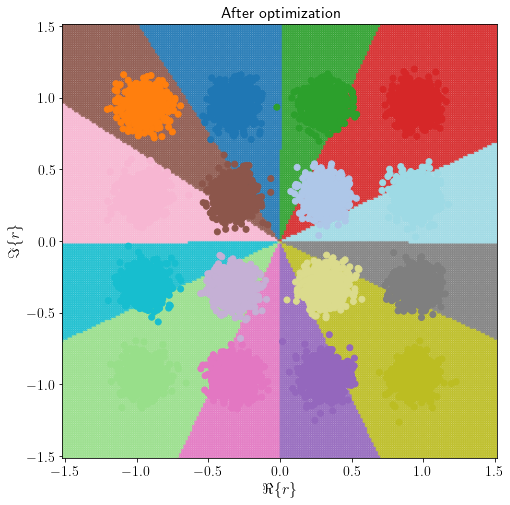

In [7]:
# Build dataset
SNR = 19 #dB

# Transmit data (bits)
ti = np.random.randint(len(constellation),size=length)
t = constellation[ti]
# Channel output
r = simulate_channel(t, SNR)
inputs = np.column_stack((np.real(r), np.imag(r)))


# random weights to start with
np.random.seed(1)
n = len(constellation)
weights = np.random.randn(2,n)

# main gradient descent loop
for i in range(1000):            
    if i % 100 == 0:
        preds = np.argmax(logistic_prediction(inputs, weights), axis=1)
        error_rate = np.mean(preds != ti)
        print('Step',i,' : ',error_rate,' error_rate with loss ',training_loss(inputs, weights))
    weights -= training_gradient(inputs, weights) * 0.01
    
plot_dec(ti, r, weights, 'After optimization')

In [8]:
def logistic_prediction_bias(x, theta, bias):
    return softmax(np.dot(x,theta)+bias)

def training_loss_bias(inputs, theta, bias):
    # Training loss is the negative log-likelihood of the training labels.
    preds = logistic_prediction_bias(inputs, theta, bias)    
    label_probabilities = preds[np.arange(length), ti]

    return -np.sum(np.log(label_probabilities))

# Function that computes the gradient 'by hand', i.e., by carrying out the maths
def training_gradient_bias(inputs, theta, bias):
    n = len(bias)
    preds = logistic_prediction_bias(inputs, theta, bias)
    
    retval_theta = np.zeros_like(theta)
    retval_bias = np.zeros_like(bias)
    
    targets = np.eye(n)[ti]
    
    for j in range(n):
        retval_theta[:,j] = (preds[:,j] - targets[:,j]) @ inputs
        retval_bias[j] = np.sum(preds[:,j] - targets[:,j])
    return retval_theta, retval_bias

Step 0  :  1.0  error_rate with loss  42444.14111862929
Step 100  :  0.0001  error_rate with loss  107.22446752754888
Step 200  :  0.0001  error_rate with loss  92.32033700344721
Step 300  :  0.0001  error_rate with loss  84.141864272061
Step 400  :  0.0001  error_rate with loss  78.33753555219003
Step 500  :  0.0001  error_rate with loss  73.74948401353886
Step 600  :  0.0001  error_rate with loss  69.92189982043234
Step 700  :  0.0001  error_rate with loss  66.62950195603237
Step 800  :  0.0001  error_rate with loss  63.7420137619983
Step 900  :  0.0001  error_rate with loss  61.175277961608245


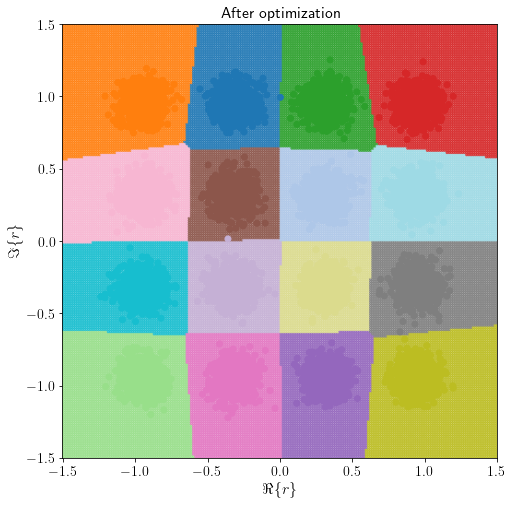

In [9]:
# Build dataset
SNR = 19 #dB

# Transmit data (bits)
ti = np.random.randint(len(constellation),size=length)
t = constellation[ti]
# Channel output
r = simulate_channel(t, SNR)
inputs = np.column_stack((np.real(r), np.imag(r)))


# random weights to start with
np.random.seed(1)
weights_theta = np.random.randn(2,n)
weights_bias = np.random.randn(n)

for i in range(1000):            
    if i % 100 == 0:
        preds = np.argmax(logistic_prediction_bias(inputs, weights_theta, weights_bias), axis=1)
        error_rate = np.mean(preds != ti)
        print('Step',i,' : ',error_rate,' error_rate with loss ',training_loss_bias(inputs, weights_theta, weights_bias))
    grad_w,grad_b = training_gradient_bias(inputs, weights_theta, weights_bias) 
    weights_theta -= 0.01 * grad_w
    weights_bias -= 0.01 * grad_b
    
plot_dec_bias(ti, r, weights_theta, weights_bias, 'After optimization')